In [45]:
import sys
from pathlib import Path

# add project root to Python path
ROOT_DIR = Path.cwd().parent
sys.path.append(str(ROOT_DIR))

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from src.prepare_data import check_for_leakage, get_train_generator, get_test_and_valid_generator, compute_class_freqs, get_weighted_loss
from src import util

In [46]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

In [47]:
train_df = pd.read_csv(ROOT_DIR / "data/nih/train-small.csv")
valid_df = pd.read_csv(ROOT_DIR / "data/nih/valid-small.csv")
test_df = pd.read_csv(ROOT_DIR / "data/nih/test.csv")

In [48]:
train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [49]:
print("leakage between train and valid:",
      check_for_leakage(train_df, valid_df, "PatientId"))

print("leakage between train and test:",
      check_for_leakage(train_df, test_df, "PatientId"))

print("leakage between valid and test:",
      check_for_leakage(valid_df, test_df, "PatientId"))

leakage between train and valid: True
leakage between train and test: False
leakage between valid and test: False


In [50]:
IMAGE_DIR = ROOT_DIR / "data/nih/images-small"

train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator = get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 1000 validated image filenames.
getting valid and test generators...
Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9120169..1.9989136].


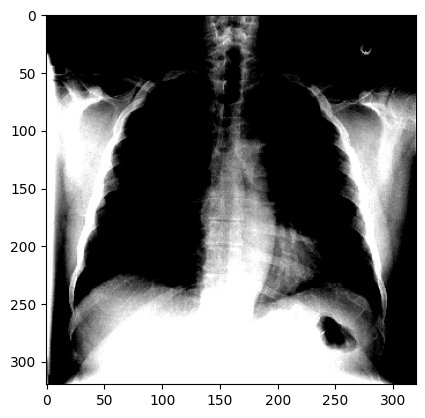

In [51]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

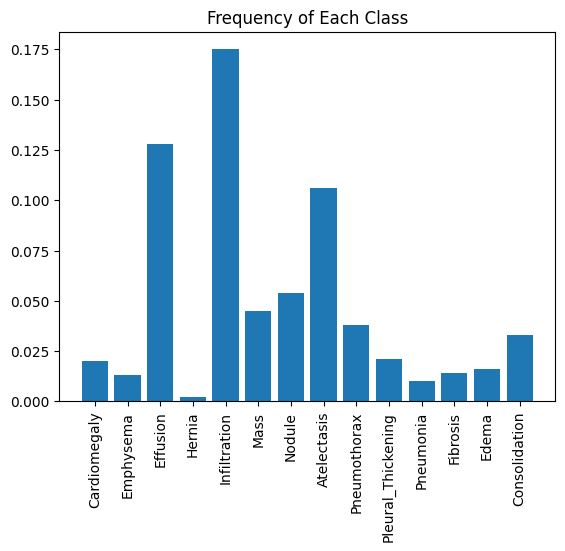

In [52]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [53]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

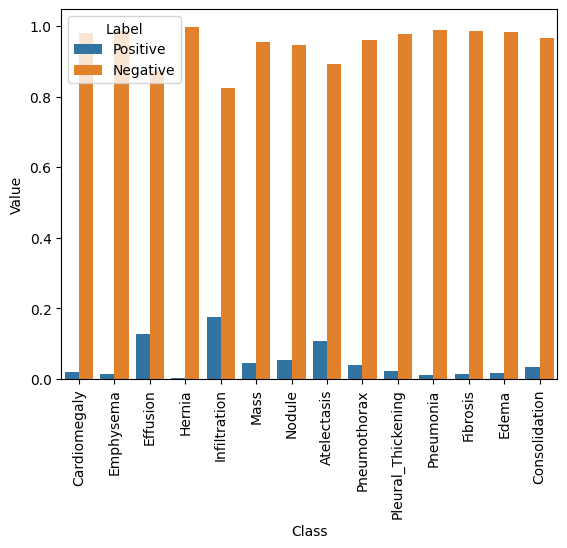

In [54]:
data = pd.DataFrame({
    "Class": labels,
    "Label": "Positive",
    "Value": freq_pos
})

neg_df = pd.DataFrame([
    {"Class": labels[l], "Label": "Negative", "Value": v}
    for l, v in enumerate(freq_neg)
])

data = pd.concat([data, neg_df], ignore_index=True)

plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [55]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

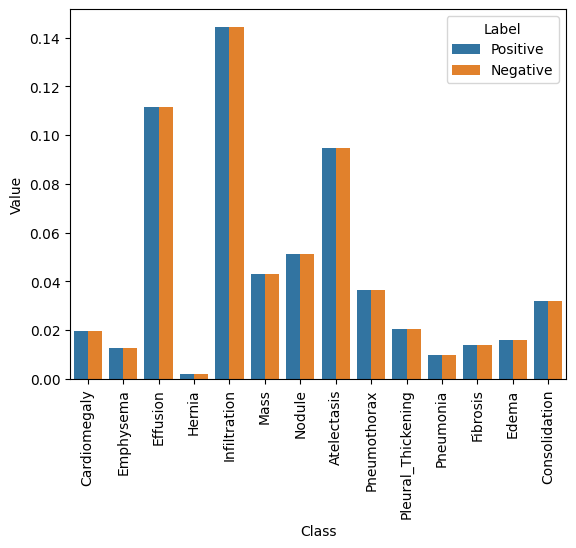

In [56]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})

neg_df = pd.DataFrame([
    {"Class": labels[l], "Label": "Negative", "Value": v}
    for l, v in enumerate(neg_contribution)
])

data = pd.concat([data, neg_df], ignore_index=True)

plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [57]:
base_model = DenseNet121(weights=ROOT_DIR / 'models/nih/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

In [58]:
model.load_weights(ROOT_DIR / "models/nih/pretrained_model.h5")

In [59]:
predicted_vals = model.predict(test_generator, steps = len(test_generator))

53/53 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step 


c:\Users\Beqa\OneDrive\Desktop\chest_xray_classifier\src\util.py:98: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1, figsize=(10, 10))
c:\Users\Beqa\OneDrive\Desktop\chest_xray_classifier\src\util.py:98: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1, figsize=(10, 10))
c:\Users\Beqa\OneDrive\Desktop\chest_xray_classifier\src\util.py:98: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1, figsize=(10, 10))
c:\Users\Beqa\OneDrive\Desktop\chest_xray_classifier\src\util.py:98: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1, figsize=(10, 10))
c:\Users\Beqa\OneDrive\Desktop\chest_xray_classifier\src\util.py:98: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1, figsize=(10, 10))


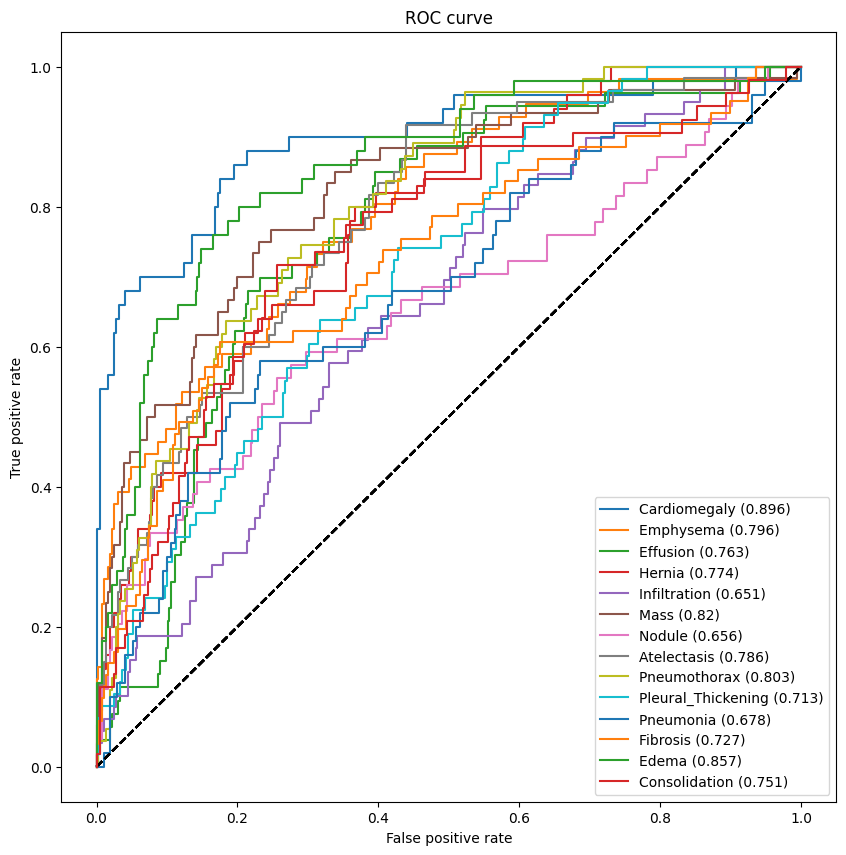

In [60]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

In [61]:
print(type(auc_rocs))
print(len(auc_rocs))
print(auc_rocs[:5])

<class 'list'>
14
[0.8959459459459459, 0.795820251177394, 0.7631998354840368, 0.7738378378378379, 0.6512512324522278]


In [62]:
df = pd.read_csv(ROOT_DIR / "data/nih/train-small.csv")
IMAGE_DIR = ROOT_DIR / "data/nih/images-small/"

# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


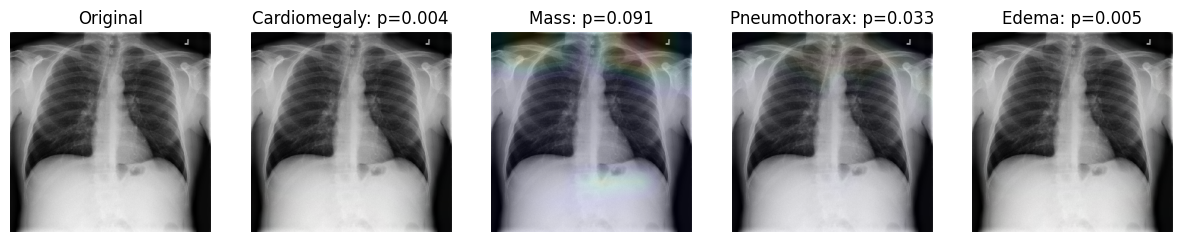

In [63]:
util.compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


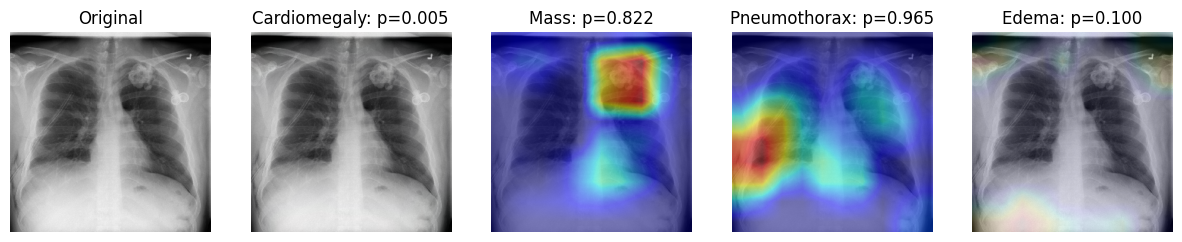

In [64]:
util.compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


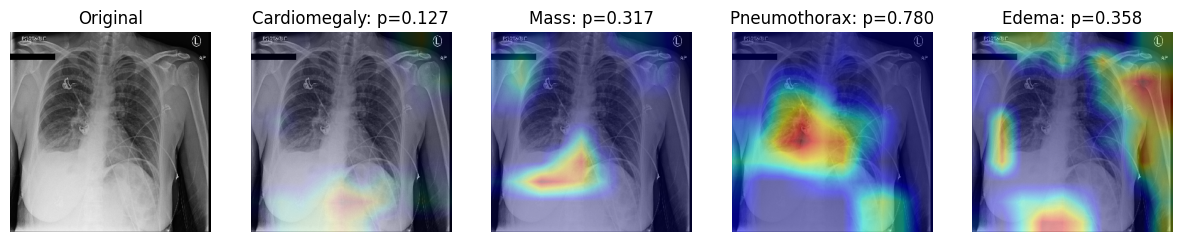

In [65]:
util.compute_gradcam(model, '00029855_001.png', IMAGE_DIR, df, labels, labels_to_show)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


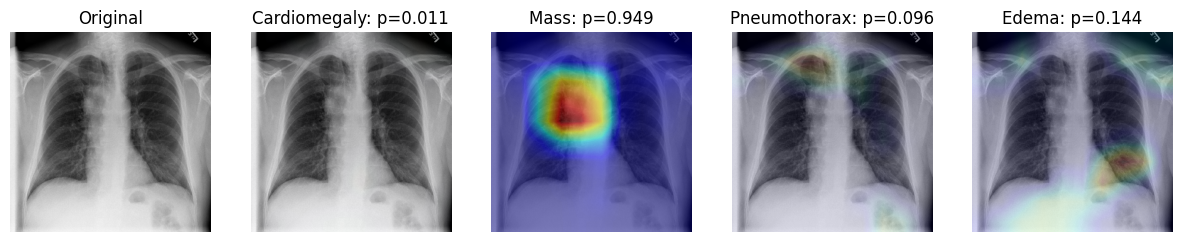

In [66]:
util.compute_gradcam(model, '00005410_000.png', IMAGE_DIR, df, labels, labels_to_show)

In [67]:
import os
from tensorflow.keras.preprocessing import image

def get_mean_std_per_batch(image_dir, df, H=320, W=320):
    sample_data = []
    for img in df.sample(100)["Image"].values:
        image_path = os.path.join(image_dir, img)
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data, axis=(0, 1, 2, 3))
    std = np.std(sample_data, axis=(0, 1, 2, 3), ddof=1)
    return mean, std

In [68]:
def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    mean, std = get_mean_std_per_batch(image_dir, df, H=H, W=W)
    img_path = os.path.join(image_dir, img)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

In [69]:
import tensorflow as tf

img = load_image('00008270_015.png', IMAGE_DIR, train_df, H=224, W=224)
print("INPUT STATS:",
      img.min(), img.max(), img.mean(), img.std())

pred = model(img, training=False)
print("PRED MAX:", tf.reduce_max(pred).numpy())


INPUT STATS: -1.9704795153329349 1.9257184365618387 -0.04906167117847247 1.1041773866655173
PRED MAX: 0.30245408
